# Выбор локации для скважины

## Загрузка и подготовка данных

Итак, нам необходимо на основе машинного обучения выбрать один из трех регионов для разработки 200 нефтянных скважин. Следует учитывать, что вероятность убытков разработки месторождений не должна превышать 2.5% при стоимости 450 рублей за один баррель и общем бюджете на разработку 10 млрд рублей.

Исходя из заданиясоставим небольшой план действий:
- изучим данные;
- обучим модель;
- оценим необходимый объем продукта для безубыточной разработки;
- расчитаем прибыли и убытки по предсказаниям модели, в том чсисле используя технику "Bootstrap".

Первым делом загрузим необходимые для проведения исследования библиотеки.

In [ ]:
import pandas as pd

import numpy as np
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


Попытался разделить библиотеки. Про пакет isort начал читать. Пока немного сложновато, но обязательно справлюсь.

Загрузим имеющиеся данные по трем регионам.

In [ ]:
try:
    data_0 = pd.read_csv('geo_data_0.csv')
except:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


Мда.... Ничего не понятно. Просто цифры. Ну и явный целевой признак - " product".

Изучим тип данных и вероятные пропуски.

In [ ]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет,данные имеют формат float64, что являяется приемлимым форматом для обучения модели типа линейная регрессия (По условиям задачи мы должныприменять именно линейную регрессию, как наиболее предсказуемую модель).

Посмотрим на распределдение количества нефти в скважинах первого региона. 

<AxesSubplot:>

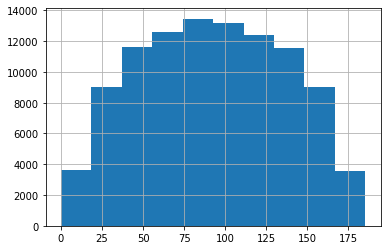

In [ ]:
data_0['product'].hist()

На гистограмме видим нормальное распределение. Значительная часть скважин имеет запасы нефти в диапазоне от 20 до 165 тысяч баррелей.


Попробуем найти связь между колличеством продукта и каждой из трех характеристик скважин методом корреляции.

In [ ]:
print(data_0.corr())

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


Незначительная связь только с третьим показателем

Просмотрим данные по второму и третьему региону.

In [ ]:
try:
    data_1 = pd.read_csv('geo_data_1.csv')
except:
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [ ]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Распределение

<AxesSubplot:>

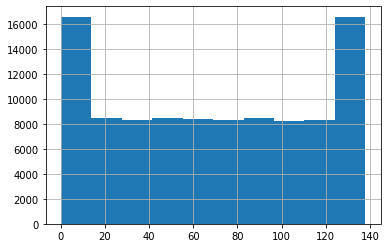

In [ ]:
data_1['product'].hist()


Очень странно распределены показатели количества продукта во втором регионе. Тут мы имеем какбольшое количество почти пустых скважин, так и потенциально прибыльных. Поэтому, забегая вперед, в ходе исследовании я выбрал второй регион не смотря на низкий средний показатель продукта. Тоесть модель позволяет выбрать те самые прибыльные скважины

Корреляция

In [ ]:
print(data_1.corr())

               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


Ого! Как интересно. Очень сильная взаимосвязь так же с третьим показателем.

In [ ]:
try:
    data_2 = pd.read_csv('geo_data_2.csv')
except:
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [ ]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Ситуация с данными такая же как и в первом регионе.

Распределение.

<AxesSubplot:>

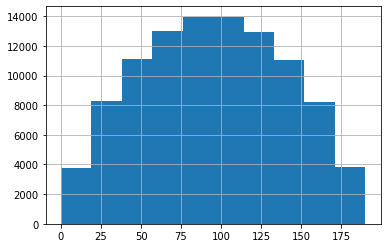

In [ ]:
data_2['product'].hist()

Переменная показателя количества нефти распределена нормально.

Корреляция

In [ ]:
print(data_2.corr())

               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


Очень похожи первый и третий регион.

Думаю можно переходить к обучению моделей.

## Обучение и проверка модели

Обучим модель типа линейная регрессия. Для этого разделим выборку на обучающую и валидационную в соотношении 75:25.

Так же кроме целевого признака ("product") удалим из "features" колонку "id", так как она не несет никакой полезной информации и может простозамедлить процесс обучения или привести к его некорректной работе. (не думаю,что это обязательно)

In [ ]:
target_0 = data_0['product']
features_0 = data_0.drop(['product', 'id'], axis=1)
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=12345)

In [ ]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0) 
predictions_0 = model_0.predict(features_valid_0)
result_0 = mean_squared_error(target_valid_0, predictions_0)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result_0)
print("Cредний запас предсказанного сырья в первом регионе:", predictions_0.mean())
print("Cредний запас сырья в первом регионе:", data_0['product'].mean())


RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813
Cредний запас предсказанного сырья в первом регионе: 92.59256778438035
Cредний запас сырья в первом регионе: 92.50000000000001


RMSE достаточно высокий, что говорит о не очень хорошем качестве модели. Однако средние предсказанныем показатели количества продукта практически соответствуют реальным.

In [ ]:
target_1 = data_1['product']
features_1 = data_1.drop(['product', 'id'], axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=12345)
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1) 
predictions_1 = model_1.predict(features_valid_1)
result_1 = mean_squared_error(target_valid_1, predictions_1)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result_1)
print("Cредний запас предсказанного сырья во втором регионе:", predictions_1.mean())
print("Cредний запас сырья во второмм регионе:", data_1['product'].mean())


RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617
Cредний запас предсказанного сырья во втором регионе: 68.728546895446
Cредний запас сырья во второмм регионе: 68.82500000000002


Отличный показатель RMSE. Однако среднее количество продукта в регионе значительно ниже чем в первом. Выводы делать рано,но думаю такая просадка по среднему количеству продукта в скважинах делает этот регион явным аутсайдером.

In [ ]:
target_2 = data_2['product']
features_2 = data_2.drop(['product', 'id'], axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=12345)
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2) 
predictions_2 = model_2.predict(features_valid_2)
result_2 = mean_squared_error(target_valid_2, predictions_2)**0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result_2)
print("Cредний запас предсказанного сырья в третьем регионе:", predictions_2.mean())
print("Cредний запас сырья в третьем регионе:", data_2['product'].mean())


RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434
Cредний запас предсказанного сырья в третьем регионе: 94.96504596800489
Cредний запас сырья в третьем регионе: 95.00000000000004


В третьем регионе примерно такие же показатели RMSE  и среднего количества продукта как и в первом.

Я хотел написать функцию. Это действительно бы очень упростило, так как я реально несколько раз путался и приходилось всеудалять и начинать сначала. Однако, недавно посмотрел какое-то видео, которое немного ввело меня в ступор, где было сказано, что начинающим датасаентистам не стоит перебарщивать с функциями. Я обязательно учту твою рекомендацию в будущем. Сейчас не хочу переписывать,боюсь, что опять наделаю ошибок:(((

## Подготовка к расчёту прибыли

Сохраним ключевые данные в отдельные переменные.

In [ ]:
budget = 10000000000
price = 450000
number = 200
max_probability_of_loss = 0.025


Оценим необходимы средний показатель количества нефти в скважинах.

In [ ]:
required_minimum = budget / number / price
print("Необходимый средний показатель количества продукта в скважинах в разрабатываемом регионе должен составлять не менее:", required_minimum)

Необходимый средний показатель количества продукта в скважинах в разрабатываемом регионе должен составлять не менее: 111.11111111111111


Ни один регион не соответствует необходимы средним показателям, в связи с чем без корректных предсказаний количества продукта в скважинах выйти не безуботочную разработку 200 местарождений в определенном регионе практически невозможно.

## Расчёт прибыли и рисков 

### Первый регион.

Расчитаем прибыли по выбранным скважинам и предсказаниямм модели.

Напишем функцию расчета прибыли для 200 лучших месторождений из пятисот выбранных.

In [ ]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return selected.sum()*price - budget


И посчитаем на основании формулы прибыль для первого региона.

Применим технику "Bootstrap" с 1000 выборок, чтобы найти распределение прибыли. Затем определим 95% доверительный интервал и риск убытков.

In [ ]:
state = np.random.RandomState(12345)


In [ ]:
target_0 = pd.Series(target_valid_0).reset_index(drop=True)
probabilities_0 = pd.Series(predictions_0).reset_index(drop=True)

target_0_sample = target_0.sample(500, replace=True, random_state=state)
target_0_sample.reset_index(drop=True)
probabilities_0_sample = probabilities_0[target_0_sample.index]
probabilities_0_sample.reset_index(drop=True)

res_0 = profit(target_0_sample.reset_index(drop=True), probabilities_0_sample.reset_index(drop=True), number)
 
print("Вероятная прибыль от разработки 200 лучших месторождений первого региона из пятисот случайно выбранных составит:", res_0)
values_0 = []
for i in range(1000):
    target_subsample_0 = target_0.sample(n=500, replace=True, random_state=state)
    probs_subsample_0 = probabilities_0[target_subsample_0.index]
 
    values_0.append(profit(target_subsample_0.reset_index(drop=True), probs_subsample_0.reset_index(drop=True), number))

values_0 = pd.Series(values_0)
lower_0 = values_0.quantile(max_probability_of_loss) 
upper_0 = values_0.quantile(0.975)
mean_0 = values_0.mean()
print("Средняя выручка с 1000 выборок:", mean_0)
print("5%-квантиль (начало интервала):", lower_0)
print("5%-квантиль (конец интервала):", upper_0)
if lower_0 < 0:
    print("Вероятность убытков при разработке первого региона превышает 2.5%")
else:
    print("Вероятность убытков при разработке первого региона НЕ превышает 2.5%")
print("Вероятность убытков при разработке первого региона составит", (values_0 < 0).mean()*100,'%')

Вероятная прибыль от разработки 200 лучших месторождений первого региона из пятисот случайно выбранных составит: 605464074.5689964
Средняя выручка с 1000 выборок: 395525575.0127928
5%-квантиль (начало интервала): -111215545.89049526
5%-квантиль (конец интервала): 909766941.5534226
Вероятность убытков при разработке первого региона превышает 2.5%
Вероятность убытков при разработке первого региона составит 7.000000000000001 %


Очевидно, первый регион не соответствует условиям задачи из-за высоких рисков получения убытков.

### Второй регион

Проведем такие же расчеты для второго региона.

In [ ]:
target_1 = pd.Series(target_valid_1).reset_index(drop=True)
probabilities_1 = pd.Series(predictions_1).reset_index(drop=True)

target_1_sample = target_1.sample(500, replace=True, random_state=state)
target_1_sample.reset_index(drop=True)
probabilities_1_sample = probabilities_1[target_1_sample.index]
probabilities_1_sample.reset_index(drop=True)
res_1 = profit(target_1_sample, probabilities_1_sample, number)
 
print("Вероятная прибыль от разработки 200 лучших месторождений второго региона из пятисот случайно выбранных составит:", res_1)

values_1 = []
for i in range(1000):
    target_subsample_1 = target_1.sample(n=500, replace=True, random_state=state)
    probs_subsample_1 = probabilities_1[target_subsample_1.index]
    values_1.append(profit(target_subsample_1.reset_index(drop=True), probs_subsample_1.reset_index(drop=True), number))

values_1 = pd.Series(values_1)
lower_1 = values_1.quantile(max_probability_of_loss) 
upper_1 = values_1.quantile(0.975)
mean_1 = values_1.mean()
print("Средняя выручка с 1000 выборок:", mean_1)
print("5%-квантиль (начало интервала):", lower_1)
print("5%-квантиль (конец интервала):", upper_1)
if lower_1 < 0:
    print("Вероятность убытков при разработке второго региона превышает 2.5%")
else:
    print("Вероятность убытков при разработке второго региона НЕ превышает 2.5%")
print("Вероятность убытков при разработке второго региона составит", (values_1 < 0).mean()*100,'%')

Вероятная прибыль от разработки 200 лучших месторождений второго региона из пятисот случайно выбранных составит: 128123231.43308258
Средняя выручка с 1000 выборок: 461631708.2006681
5%-квантиль (начало интервала): 78050810.7517417
5%-квантиль (конец интервала): 862952060.2637234
Вероятность убытков при разработке второго региона НЕ превышает 2.5%
Вероятность убытков при разработке второго региона составит 0.7000000000000001 %


Второй регион соответствует необходимым требованиям.

### Третий регион

Проведем расчеты по даннымиз третьего региона

In [ ]:
target_2 = pd.Series(target_valid_2).reset_index(drop=True)
probabilities_2 = pd.Series(predictions_2).reset_index(drop=True)

target_2_sample = target_2.sample(500, replace=True, random_state=state)
target_2_sample.reset_index(drop=True)
probabilities_2_sample = probabilities_2[target_2_sample.index]
probabilities_2_sample.reset_index(drop=True)

res_2 = profit(target_2_sample, probabilities_2_sample, number)
 
print("Вероятная прибыль от разработки 200 лучших месторождений первого региона из пятисот случайно выбранных составит:", res_2)
values_2 = []
for i in range(1000):
    target_subsample_2 = target_2.sample(n=500, replace=True, random_state=state)
    probs_subsample_2  = probabilities_2[target_subsample_2.index]
    target_subsample_2 = target_subsample_2.reset_index(drop=True)
    probs_subsample_2 = probs_subsample_2.reset_index(drop=True)
    values_2.append(profit(target_subsample_2, probs_subsample_2, number))

values_2 = pd.Series(values_2)
lower_2 = values_2.quantile(max_probability_of_loss) 
upper_2 = values_2.quantile(0.975)
mean_2 = values_2.mean()
print("Средняя выручка с 1000 выборок:", mean_2)
print("5%-квантиль (начало интервала):", lower_2)
print("5%-квантиль (конец интервала):", upper_2)
if lower_2 < 0:
    print("Вероятность убытков при разработке третьего региона превышает 2.5%")
else:
    print("Вероятность убытков при разработке третьего региона НЕ превышает 2.5%")
print("Вероятность убытков при разработке третьего региона составит", (values_2 < 0).mean()*100,'%')

Вероятная прибыль от разработки 200 лучших месторождений первого региона из пятисот случайно выбранных составит: 242929855.45624352
Средняя выручка с 1000 выборок: 392446381.5803063
5%-квантиль (начало интервала): -112227625.37857565
5%-квантиль (конец интервала): 934562914.5511636
Вероятность убытков при разработке третьего региона превышает 2.5%
Вероятность убытков при разработке третьего региона составит 6.5 %


Третий регион не соответствует требованиям безубыточности.

## Вывод

Проведенное иследование показало, что только второе месторождение соответствует требованиям заказчика по показателям безубыточности.